In [1]:
import jax
from typing import Any, Callable, Sequence
from jax import random, numpy as jnp
import flax
from flax import linen as nn
import optax

In [ ]:
done = jnp.array([True, False,  True, False, True], dtype=bool)
obs = jnp.array([[ 0.5162862 ,  0.2074894 ,  0.7240187 , -1.0787021 ,  0.04069785,
                 -0.06364991,  1.        ,  0.        ],
                [ 0.11500321,  1.1899251 ,  0.50547856, -0.419965  , -0.2609647 ,
                 -0.33009827,  0.        ,  0.        ],
                [-0.63004315, -0.23130883, -0.3797977 , -0.47536182,  2.8034565 ,
                  1.9403803 ,  0.        ,  0.        ],
                [-0.153934  ,  1.1053196 , -0.3867789 , -0.58739966,  0.3082726 ,
                  0.06706445,  0.        ,  0.        ],
                [-0.0033843 ,  1.4856167 ,  0.04007225,  0.00840264, -0.11051258,
                 -0.24021249,  0.        ,  0.        ]], dtype=jnp.float32)

print(done.shape)
print(obs.shape)

In [ ]:
def classify_goal(x):
    result = jnp.zeros_like(x, dtype=jnp.int32)
    result = result.at[x < -0.33].set(0)
    result = result.at[(x >= -0.33) & (x < 0.33)].set(1)
    result = result.at[x >= 0.33].set(2)

    return result

done_idx = jnp.argwhere(done).reshape(-1)
goal_idx = classify_goal(obs[done_idx, 0])

print(done_idx)
print(obs[done_idx, 0])
print(goal_idx)

In [ ]:
from craftax_classic.envs.craftax_symbolic_env import CraftaxClassicSymbolicEnv
from environment_base.wrappers import AutoResetEnvWrapper, BatchEnvWrapper

rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
rngs = jax.random.split(_rng, 3)

# Create environment
env = AutoResetEnvWrapper(CraftaxClassicSymbolicEnv())
env_params = env.default_params

# Get an initial state and observation
obs, state = env.reset(rngs[0], env_params)

# Pick random action
action = env.action_space(env_params).sample(rngs[1])

# Step environment
obs, state, reward, done, info = env.step(rngs[2], state, action, env_params)

# print(all_map.flatten().shape)
# print(inventory.shape)
# print(intrinsics.shape)
# print(direction.shape)
# print(jnp.array([state.light_level, state.is_sleeping]).shape)

In [ ]:
state.achievements.shape

In [ ]:
# Load iris dataset from sklearn
from sklearn.datasets import load_iris
iris = load_iris()

# Extract features and labels
X = iris.data
y = iris.target

# Convert X and y into jnp arrays
X = jnp.array(X)
y = jnp.array(y)

# Convert y into one hot
y = jnp.eye(3)[y]

print(X.shape, y.shape)

In [ ]:
class MLP(nn.Module):
    hidden1_size: int
    hidden2_size: int
    hidden3_size: int
    output_size: int
    
    dropout_rate: float

    @nn.compact
    def __call__(self, x, train=False):
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden1_size)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden2_size)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not train)
        x = nn.Dense(features=self.hidden3_size)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.output_size)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
key = jax.random.PRNGKey(0)
input_shape = (768,)

model = MLP(hidden1_size=64, hidden2_size=64, hidden3_size=16, output_size=3, dropout_rate=0.2)
params = model.init(key, jnp.ones(input_shape, jnp.float32))

print(model)

In [ ]:
dummy_obs = jnp.ones((10, 1345))

blocks_labels = ['invalid', 'out of bounds', 'grass', 'water', 'stone', 'tree', 'wood', 'path', 'coal', 'iron', 'diamond', 'crafting table', 'furnace', 'sand', 'lava', 'plant', 'ripe plant']
mobs_labels = ['zombie', 'cow', 'skeleton', 'arrow']
inventory_labels = ['wood', 'stone', 'coal', 'iron', 'diamond', 'sapling', 'wood pickaxe', 'stone pickaxe', 'iron pickaxe', 'wood sword', 'stone sword', 'iron sword']

health_labels = ['very unhealthy', 'unhealthy', 'at okay health', 'healthy', 'very healthy']
food_labels = ['very hungry', 'hungry', 'at okay hunger', 'full', 'very full']
thirsty_labels = ['very thirsty', 'thirsty', 'at okay thirst', 'thirsty', 'very thirsty']
energy_labels = ['very tired', 'tired', 'at okay energy', 'well-rested', 'very well-rested']

def embedding_crafter(next_obs, _):
    batch_size = next_obs.shape[0]
    maps, metadata = jnp.split(next_obs, [7 * 9 * 21], axis=1)
    
    # For each block/mob type, count how many are in frame
    maps = jnp.reshape(maps, [-1, 7, 9, 21])
    maps = jnp.transpose(maps, [0, 3, 1, 2])
    maps = jnp.reshape(maps, [-1, 21, 7 * 9])
    maps = maps.sum(axis=2)
    maps = jnp.round(maps).astype(jnp.int32)
    blocks, mobs = jnp.split(maps, [17], axis=1)

    # Extract and format metadata
    inventory, intrinsics, direction, light_level, is_sleeping = jnp.split(metadata, [12, 16, 20, 21], axis=1)
    inventory = jnp.round(inventory * 10.0).astype(jnp.int32)
    intrinsics *= 10.0

    health, food, drink, energy = jnp.split(intrinsics, [1, 2, 3], axis=1)

    # Construct embedding
    for i in range(batch_size):
        blocks_gt0 = jnp.argwhere(blocks[i] > 0).reshape(-1)
        mobs_gt0 = jnp.argwhere(mobs[i] > 0).reshape(-1)
        inventory_gt0 = jnp.argwhere(inventory[i] > 0).reshape(-1)

        blocks_str = 'You see the following blocks: {}.'.format(', '.join([blocks_labels[b] for b in blocks_gt0]))
        mobs_str = 'You see the following mobs: {}.'.format(', '.join([mobs_labels[m] for m in mobs_gt0]))
        inventory_str = 'You have in your inventory: {}.'.format(', '.join([inventory_labels[i] for i in inventory_gt0]))

        health_str = 'Your health level is: {}.'.format(health_labels[round(health[i].item() / 2.0) - 1])
        food_str = 'Your hunger level is: {}.'.format(food_labels[round(food[i].item() / 2.0) - 1])
        drink_str = 'Your thirst level is: {}.'.format(thirsty_labels[round(drink[i].item() / 2.0) - 1])
        energy_str = 'Your energy level is: {}.'.format(energy_labels[round(energy[i].item() / 2.0) - 1])

        desc = [health_str, food_str, drink_str, energy_str]
        if len(blocks_gt0) > 0:
            desc.append(blocks_str)
        if len(mobs_gt0) > 0:
            desc.append(mobs_str)
        if len(inventory_gt0) > 0:
            desc.append(inventory_str)

        desc = ' '.join(desc)

    return intrinsics

embedding_crafter(dummy_obs, None)

In [ ]:
import jax.numpy as jnp

# Calculate mutual information given a normalized 3 x 3 matrix
def normalize_freq_matrix(freq_matrix):
    if jnp.sum(freq_matrix) < 1e-9:
        return jnp.zeros((3, 3))
    
    conf_matrix = freq_matrix / (jnp.sum(freq_matrix, axis=1, keepdims=True) + 1e-9)
    return conf_matrix

def I_zs_score(freq_matrix):
    freq_matrix = normalize_freq_matrix(freq_matrix)

    total_freq = jnp.sum(freq_matrix)
    if total_freq < 1e-9:
        return 0.0
    
    p_y = jnp.sum(freq_matrix, axis=0) / total_freq
    p_yhat = jnp.sum(freq_matrix, axis=1) / total_freq
    p_y_yhat = freq_matrix / total_freq
    
    mi = 0.0
    for i in range(3):
        for j in range(3):
            if p_y_yhat[i, j] > 0 and p_y[i] > 0 and p_yhat[j] > 0:
                mi += p_y_yhat[i, j] * jnp.log(p_y_yhat[i, j] / (p_y[i] * p_yhat[j] + 1e-9))

    return mi

I_zs_score(jnp.array([[2.0, 18.0, 4.0],
                      [2.0, 2.0, 8.0],
                      [8.0, 14.0, 2.0]]))

In [ ]:
class QNetCraftax(nn.Module):
    action_size: 17

    @nn.compact
    def __call__(self, x):
        maps, metadata = jnp.split(x, [7 * 9 * 21], axis=1)
        maps = maps.reshape((-1, 7, 9, 21))
        
        maps = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(maps)
        maps = nn.relu(maps)
        maps = nn.max_pool(maps, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        maps = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(maps)
        maps = nn.relu(maps)
        maps = nn.max_pool(maps, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        maps = maps.reshape((maps.shape[0], -1))

        y = jnp.concatenate((maps, metadata), axis=-1)
        y = nn.Dense(128)(y)
        y = nn.relu(y)
        y = nn.Dense(64)(y)
        y = nn.relu(y)
        y = nn.Dense(self.action_size)(y)
        y = nn.softmax(y)
        return y

In [ ]:
key = jax.random.PRNGKey(0)
model = QNetCraftax(action_size=17)
params = model.init(key, dummy_obs)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8500
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


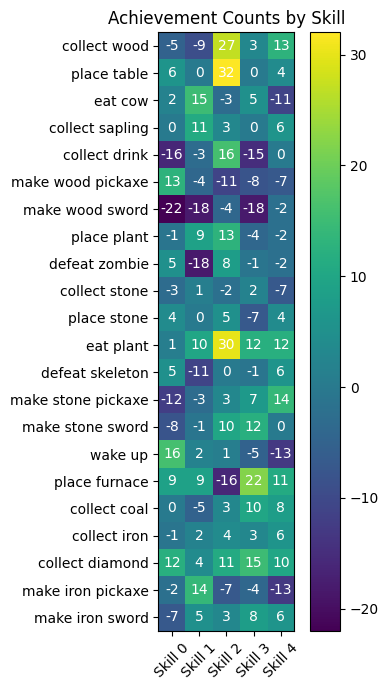

In [2]:
import matplotlib.pyplot as plt

skill_size = 5
skill_labels = [f'Skill {i}' for i in range(skill_size)]
achievement_labels = ['collect wood', 'place table', 'eat cow', 'collect sapling', 'collect drink', 'make wood pickaxe', 'make wood sword', 'place plant', 'defeat zombie', 'collect stone', 'place stone', 'eat plant', 'defeat skeleton', 'make stone pickaxe', 'make stone sword', 'wake up', 'place furnace', 'collect coal', 'collect iron', 'collect diamond', 'make iron pickaxe', 'make iron sword']
achivement_counts = jax.random.normal(key=jax.random.PRNGKey(0), shape=(skill_size, 22)) * 10 + 3.0
achivement_counts = achivement_counts.astype(int)

plt.figure(figsize=(4, 7))
plt.imshow(achivement_counts.T)
plt.xticks(range(skill_size), skill_labels, rotation=45)
plt.yticks(range(22), achievement_labels)
plt.title('Achievement Counts by Skill')
plt.tight_layout()
plt.colorbar()

for i in range(22):
    for j in range(skill_size):
        text = plt.text(j, i, round(achivement_counts[j, i], 1),
                       ha="center", va="center", color="w")

plt.show()

In [14]:
from models import QNetCraftax, Discriminator
from ml_collections import ConfigDict
from craftax_classic.envs.craftax_symbolic_env import CraftaxClassicSymbolicEnv
from craftax_classic.renderer import render_craftax_pixels
from environment_base.wrappers import BatchEnvWrapper
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageSequence
import IPython
import numpy as np
from tqdm import tqdm
import wandb

from crafter_constants import action_names

config = ConfigDict({
    'state_size': 1345,
    'skill_size': 5,
    'embedding_size': 1345,
    'action_size': 17,
    'policy_units': 1024,
    'discrim_units': 1024,
    'dropout_rate': 0.2
})

qlocal_key = jax.random.PRNGKey(0)
discrim_key = jax.random.PRNGKey(1)
dummy_state = jnp.zeros((1, config.state_size))
dummy_embedding = jnp.zeros((1, config.embedding_size))
dummy_skill = jnp.zeros((1, config.skill_size))

qlocal = QNetCraftax(
    action_size=config.action_size,
    hidden1_size=config.policy_units,
    hidden2_size=config.policy_units,
    dropout_rate=config.dropout_rate
)
qlocal_params = qlocal.init(qlocal_key, dummy_state, dummy_skill, train=False)

discrim = Discriminator(
    skill_size=config.skill_size,
    hidden1_size=config.discrim_units,
    hidden2_size=config.discrim_units,
    dropout_rate=config.dropout_rate
)
discrim_params = discrim.init(discrim_key, dummy_embedding, train=False)

In [6]:
env = CraftaxClassicSymbolicEnv()
env_params = env.default_params

In [16]:
key = random.PRNGKey(0)

def gather_rollouts(key, embedding_fn, skill_size, num_rollouts=5, max_steps_per_rollout=500):
    skill_rollouts = []
    for skill_idx in range(skill_size):
        skill = jax.nn.one_hot(skill_idx, config.skill_size)
        rollouts = []
        for _ in tqdm(range(num_rollouts)):
            key, env_init_key = random.split(key, num=2)
            obs, state = env.reset(env_init_key, env_params)

            rollout = []
            for t in tqdm(range(max_steps_per_rollout), leave=False):
                key, env_step_key = random.split(key, num=2)
                
                qvalues = qlocal.apply(qlocal_params, obs.reshape(1, -1), skill.reshape(1, -1), train=False)
                action_probs = jax.nn.softmax(qvalues)[0]
                action = jnp.argmax(qvalues, axis=-1).item()

                next_obs, state, reward, done, info = env.step(env_step_key, state, action, env_params)
                next_obs_embedding = embedding_fn(next_obs.reshape(1, -1))
                discrim_logits = discrim.apply(discrim_params, next_obs_embedding.reshape(1, -1), train=False)
                discrim_probs = jax.nn.softmax(discrim_logits)[0]

                frame = render_craftax_pixels(state, 64) / 255.0
                img = Image.fromarray(np.uint8(frame * 255)).convert('RGB')

                action_name = action_names[action]
                action_prob = round(action_probs[action].item(), 4)
                discrim_prob = round(discrim_probs[skill_idx].item(), 4)

                draw = ImageDraw.Draw(img)
                draw.text((10, 410), "t=1", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((10, 10), f"Action: {action_name}", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((10, 40), f"Action Prob: {action_prob}", (255, 255, 255), font_size=24, stroke_width=1)
                draw.text((300, 10), f"Skill {skill_idx} Prob: {discrim_prob}", (255, 255, 255), font_size=24, stroke_width=1)

                rollout.append(np.array(img))

                if done:
                    break

            rollout_tensor = np.array(rollout).transpose(0, 3, 1, 2)
            rollouts.append(rollout_tensor)
        skill_rollouts.append(rollouts)
    return skill_rollouts


rollouts = gather_rollouts(random.PRNGKey(0), lambda x: x, 3, num_rollouts=1, max_steps_per_rollout=500)

100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


In [ ]:
img = rollouts[0][0][0]

plt.figure()
plt.imshow(np.array(img))
plt.axis('off')
plt.axis("tight")
plt.axis("image")
plt.show()

In [17]:
rollouts[2][0].shape

(93, 3, 576, 576)